# Model for durable housing

In this notebook, I illustrate the results from the model.
As more of the model is solved, I'll add some results to this notebook

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from scipy import optimize

# load the DurableConsumptionModel module
from DurableConsumptionModel import DurableConsumptionModelClass

# Set the number of threads in numba
nb.set_num_threads(4)

In [43]:
# Something for figure layout


Solve and simulate the model

In [2]:
# Set time horizon
T = 200
p = 6.2

# Define the model
model = DurableConsumptionModelClass(name='example_negm',par={'solmethod':'negm','T':T, 'ph':p, 'do_print':False})

# Solve and simulate
model.precompile_numba()
model.solve()
model.simulate()

Plot policy functions

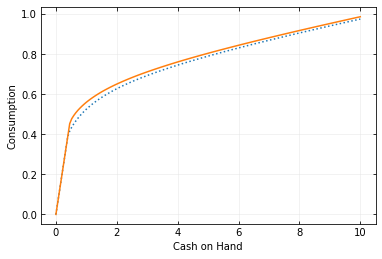

In [3]:
# Initialize the figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

# Plot the avalanche sizes
ax.plot(model.par.grid_m, model.sol.c_keep[0,1,0,1,:], linestyle = ':')
ax.plot(model.par.grid_m, model.sol.c_keep[0,1,1,1,:])


# Plot setting
ax.set_xlabel('Cash on Hand')
ax.set_ylabel('Consumption')

# ax.set_xlim(0,len(x_pareto))
# ax.set_ylim(1,50)
ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')

Show convergence

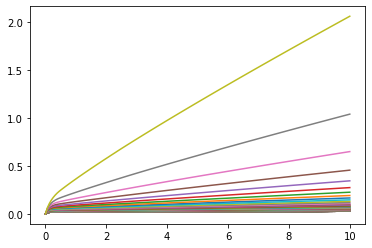

In [4]:
for t in range(T-1):
    plt.plot(model.par.grid_m, model.sol.inv_v_adj[t,0,1,:])

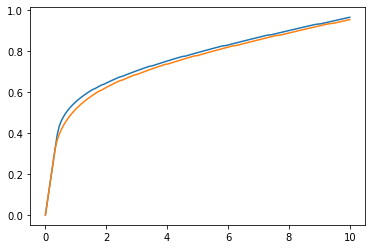

In [5]:
plt.plot(model.par.grid_m, model.sol.c_adj[0,1,1,:])
plt.plot(model.par.grid_m, model.sol.c_adj[0,1,0,:])

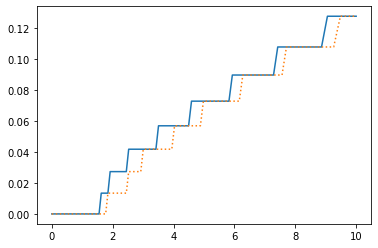

In [6]:
plt.plot(model.par.grid_m, model.sol.d_adj[0,0,1,:], linestyle = '-')
plt.plot(model.par.grid_m, model.sol.d_adj[0,0,0,:], linestyle = ':')

In [7]:
w = model.sim.m + model.par.ph*model.sim.d
m = model.sim.m

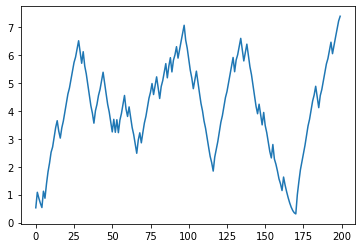

In [8]:
plt.plot(m[:,100])
# plt.scatter(range(model.par.T),model.sim.n[:,0])

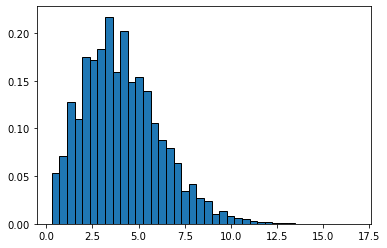

In [9]:
plt.hist(w[99,:], bins = 40, density = True, edgecolor = 'k')
plt.show()

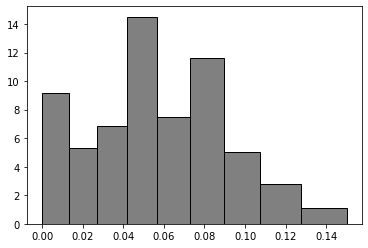

In [10]:
plt.hist(model.sim.n[-1,:], bins = model.par.grid_n, density = True, facecolor='0.5', edgecolor = 'k')
plt.show()

In [19]:
print(np.mean(model.sim.n[-1,:]))

0.04964284942862569


In [18]:
model.par.ph = 6.45
model.solve()
model.simulate()

# Find stationary equilibrium

Find demand curve over a grid of house prices

In [28]:
# Grid over house prices
Nr = 20
p_vec = np.linspace(5.5,7.0,Nr)
p_min = p_vec[0]
p_max = p_vec[Nr-1]

# Supply
Hs = 0.05 # Find some value

# Initialize demand function
Hd = np.zeros(shape=len(p_vec))

# Loop
t0 = time.time()
for i_p,p in enumerate(p_vec):
    
    # Solve and simulate model
    model.par.ph = p
    model.solve()
    model.simulate()
    
    # Aggregate demand
    Hd[i_p] = np.mean(model.sim.n[-1,:])
    
    # Bound on p
    diff = Hs - Hd[i_p]
    if diff < 0: p_min = np.fmax(p_min, p_vec[i_p])
    if diff > 0: p_max = np.fmin(p_max, p_vec[i_p])
    
    # print(i_p)
    
t1 = time.time()

In [29]:
print(t1-t0)

147.71961736679077


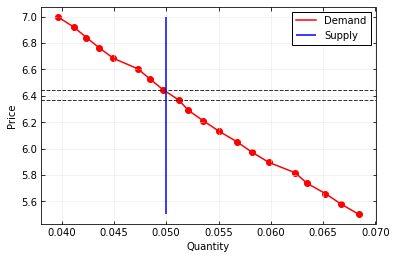

In [37]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.plot(Hd,p_vec, color = 'red', label = 'Demand')
ax.scatter(Hd,p_vec, color = 'red')

ax.vlines(Hs,5.5,7.0, color = 'blue', linestyle = '-', label ='Supply')

ax.hlines(p_min,0.035,0.08, linestyle='--', color = '0.2', linewidth = 1)
ax.hlines(p_max,0.035,0.08, linestyle='--', color = '0.2', linewidth = 1)

ax.set_xlim(0.038,0.07)
ax.set_xlabel('Quantity')
ax.set_ylabel('Price')

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/equilibrium.pdf')

Last step

In [38]:
def obj(p,model):
    
    model.par.ph = p
    model.solve()
    model.simulate()
    return np.mean(model.sim.n[-1,:]) - Hs

t0 = time.time()

opt = optimize.root_scalar(obj,bracket=[p_min,p_max],method='bisect',args=(model,),maxiter=100)
model.par.ph = opt.root
assert opt.converged

t1 = time.time()

In [50]:
model.solve()
model.simulate()

In [51]:
np.mean(model.sim.n[-1,:]) - Hs

-6.605663343643015e-05

In [52]:
opt

      converged: True
           flag: 'converged'
 function_calls: 38
     iterations: 36
           root: 6.427186923955129

In [42]:
Hs

0.05